In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, mean_absolute_error, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load the updated dataset
data = pd.read_csv("data_kaduna_plant.csv")

In [5]:
data.head()

,Order Number,Start Date,End Date,Line,Shift,Posting date,POT Min,POT Hour,Notification Number,Equiment,Downtime(in Secods),Breakdown,Group,Description,WERKS CODE,WERKS
0,10001023,04/05/2023 00:00,04/05/2023 00:00,Line 1,1,03/05/2023 00:00,0.0,0.0,10003846.0,10000940.0,NaN,no breakdown,U-STEAM,UTI_BOILER,A112,Kaduna Noodles
1,10001023,04/05/2023 00:00,04/05/2023 00:00,Line 1,1,03/05/2023 00:00,0.0,0.0,10003849.0,10000643.0,3.000000,breakdown,NaN,NaN,A112,Kaduna Noodles
2,10001024,05/05/2023 00:00,05/05/2023 00:00,Line 1,2,03/05/2023 00:00,0.0,0.0,10003886.0,NaN,40.733333,breakdown,NaN,NaN,A112,Kaduna Noodles
3,10001024,05/05/2023 00:00,05/05/2023 00:00,Line 1,2,03/05/2023 00:00,0.0,0.0,10003887.0,NaN,40.000000,breakdown,NaN,NaN,A112,Kaduna Noodles
4,30000756,03/05/2023 00:00,03/05/2023 00:00,Line 1,1,03/05/2023 00:00,0.0,0.0,NaN,NaN,NaN,no breakdown,NaN,NaN,A112,Kaduna Noodles


In [9]:
# Data Preprocessing: Convert 'Downtime(in Secods)' to numeric and 'Start Date', 'End Date' to datetime
# Convert 'Start Date', 'End Date', and 'Posting date' to datetime with dayfirst=True
data['Start Date'] = pd.to_datetime(data['Start Date'], dayfirst=True)
data['End Date'] = pd.to_datetime(data['End Date'], dayfirst=True)
data['Posting date'] = pd.to_datetime(data['Posting date'], dayfirst=True)


In [11]:
data.head()

,Order Number,Start Date,End Date,Line,Shift,Posting date,POT Min,POT Hour,Notification Number,Equiment,Downtime(in Secods),Breakdown,Group,Description,WERKS CODE,WERKS
0,10001023,2023-05-04,2023-05-04,Line 1,1,2023-05-03,0.0,0.0,10003846.0,10000940.0,NaN,no breakdown,U-STEAM,UTI_BOILER,A112,Kaduna Noodles
1,10001023,2023-05-04,2023-05-04,Line 1,1,2023-05-03,0.0,0.0,10003849.0,10000643.0,3.000000,breakdown,NaN,NaN,A112,Kaduna Noodles
2,10001024,2023-05-05,2023-05-05,Line 1,2,2023-05-03,0.0,0.0,10003886.0,NaN,40.733333,breakdown,NaN,NaN,A112,Kaduna Noodles
3,10001024,2023-05-05,2023-05-05,Line 1,2,2023-05-03,0.0,0.0,10003887.0,NaN,40.000000,breakdown,NaN,NaN,A112,Kaduna Noodles
4,30000756,2023-05-03,2023-05-03,Line 1,1,2023-05-03,0.0,0.0,NaN,NaN,NaN,no breakdown,NaN,NaN,A112,Kaduna Noodles


In [13]:
# Fill NaN Downtime where there is no breakdown with 0
data.loc[data['Breakdown'] == 'no breakdown', 'Downtime(in Secods)'] = 0

In [15]:
# Feature engineering: Add operation duration, and extract time-based features
data['Operation Duration'] = (data['End Date'] - data['Start Date']).dt.total_seconds()
data['Start Hour'] = data['Start Date'].dt.hour
data['End Hour'] = data['End Date'].dt.hour
data['Day of Week'] = data['Start Date'].dt.dayofweek

# SECTION 2: Define Features and Split Data

In [17]:
# Features and target variables
X = data.drop(columns=['Breakdown', 'Downtime(in Secods)', 'Start Date', 'End Date', 'Posting date'])
y_breakdown = data['Breakdown'].apply(lambda x: 1 if x == 'breakdown' else 0)
y_downtime = data['Downtime(in Secods)']

In [19]:
# Split the data
X_train, X_test, y_train_breakdown, y_test_breakdown = train_test_split(X, y_breakdown, test_size=0.2, random_state=42)

# SECTION 3: Define Preprocessing Steps

In [31]:
# Define categorical and numerical columns for preprocessing
categorical_cols = ['Line', 'Group', 'WERKS CODE']
numerical_cols = ['Shift', 'POT Min', 'POT Hour', 'Notification Number', 'Equiment', 'Operation Duration', 'Start Hour', 'End Hour', 'Day of Week']

In [33]:
# Create a preprocessor to handle missing values and feature transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),  # Fill missing values with mean for numerical columns
            ('scaler', StandardScaler())  # Scale the numerical features
        ]), numerical_cols),
        
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing values with most frequent for categorical columns
            ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encoding for categorical columns
        ]), categorical_cols)
    ]
)


# SECTION 4: Create and Train the Pipelines for Classification and Regressio

In [35]:
# Define the classification model pipeline
clf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [37]:
# Define the regression model pipeline
reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])


In [39]:
# Train the classification model pipeline
clf_pipeline.fit(X_train, y_train_breakdown)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Shift', 'POT Min',
                                                   'POT Hour',
                                                   'Notification Number',
                                                   'Equiment',
                                                   'Operation Duration',
                                                   'Start Hour', 'End Hour',
                                                   'Day of Week']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Line', 'Group',
                                                   'WERKS CODE'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [41]:
# Now for regression, we'll only train on rows where breakdown occurred
X_train_downtime = X_train[y_train_breakdown == 1]
y_train_downtime = y_downtime[X_train.index[y_train_breakdown == 1]]
reg_pipeline.fit(X_train_downtime, y_train_downtime)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Shift', 'POT Min',
                                                   'POT Hour',
                                                   'Notification Number',
                                                   'Equiment',
                                                   'Operation Duration',
                                                   'Start Hour', 'End Hour',
                                                   'Day of Week']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Line', 'Group',
                                                   'WERKS CODE'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

# SECTION 5: Predict Breakdown and Downtime for Multiple Rows

In [45]:
def predict_breakdown_and_downtime(X_new):
    """
    Predict breakdown and downtime for multiple rows.
    
    Args:
    - X_new: New data (multiple rows) for which we want to predict.
    
    Returns:
    - A DataFrame with predicted breakdowns and corresponding downtimes.
    """
    # Predict breakdowns
    breakdown_pred = clf_pipeline.predict(X_new)
    
    # Initialize a list to store downtime predictions
    downtime_preds = []
    
    # Iterate through the predictions to predict downtime if a breakdown occurred
    for i, breakdown in enumerate(breakdown_pred):
        if breakdown == 1:
            # Predict downtime if there was a breakdown
            downtime_pred = reg_pipeline.predict(X_new.iloc[[i]])[0]
            downtime_preds.append(downtime_pred)
        else:
            # No downtime if no breakdown occurred
            downtime_preds.append(None)
    
    # Create a DataFrame with both predictions
    results_df = X_new.copy()
    results_df['Breakdown Prediction'] = breakdown_pred
    results_df['Downtime Prediction'] = downtime_preds
    
    return results_df

# SECTION 6: Example Prediction with Multiple Rows

In [71]:
X_new = X_test  # Use the entire test set for prediction
prediction_results = predict_breakdown_and_downtime(X_new)

In [73]:
X_new.head()

,Order Number,Line,Shift,POT Min,POT Hour,Notification Number,Equiment,Group,Description,WERKS CODE,WERKS,Operation Duration,Start Hour,End Hour,Day of Week
2572,10005294,Line 2,1,0.0,0.00,10021776.0,10001045.0,E-FRY,ENG_FRYER,A112,Kaduna Noodles,0.0,0,0,0
6311,10017845,Line 4,2,705.0,11.75,10070857.0,10001270.0,E-FRY,ENG_FRYER,A112,Kaduna Noodles,86400.0,0,0,1
6816,10024732,Line 4,2,705.0,11.75,10096369.0,10001307.0,E-AD,ENG_AUTO DISPENSER,A112,Kaduna Noodles,86400.0,0,0,4
5780,10010080,Line 4,1,705.0,11.75,10040995.0,NaN,U-POWER,UTI_GENERATOR,A112,Kaduna Noodles,0.0,0,0,3
3404,30005810,Line 2,2,0.0,0.00,NaN,NaN,NaN,NaN,A112,Kaduna Noodles,0.0,0,0,1


In [51]:
# Display the first few rows of the prediction results
print(prediction_results[['Breakdown Prediction', 'Downtime Prediction']].head())

      Breakdown Prediction  Downtime Prediction
2572                     1               20.800
6311                     1               97.370
6816                     1               11.717
5780                     1               95.810
3404                     0                  NaN


# SECTION 7: Model Evaluation

In [53]:
# Classification Metrics: Accuracy, Confusion Matrix, F1 Score
y_pred_breakdown = clf_pipeline.predict(X_test)

print("Classification Report:")
print(classification_report(y_test_breakdown, y_pred_breakdown))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.90      0.95       646
           1       0.95      1.00      0.97      1143

    accuracy                           0.96      1789
   macro avg       0.97      0.95      0.96      1789
weighted avg       0.96      0.96      0.96      1789



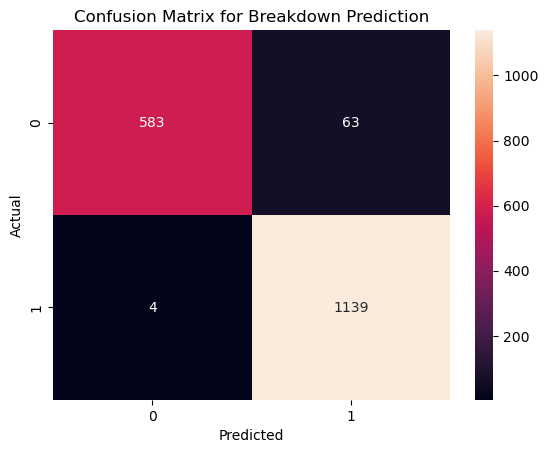

In [55]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test_breakdown, y_pred_breakdown)
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.title("Confusion Matrix for Breakdown Prediction")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [57]:
# Regression Metrics: MAE and Residual Plot
y_pred_downtime = reg_pipeline.predict(X_test[y_pred_breakdown == 1])
mae = mean_absolute_error(y_test_breakdown[y_pred_breakdown == 1], y_pred_downtime)
print("Mean Absolute Error for Downtime Prediction:", mae)

Mean Absolute Error for Downtime Prediction: 18.7601697726013


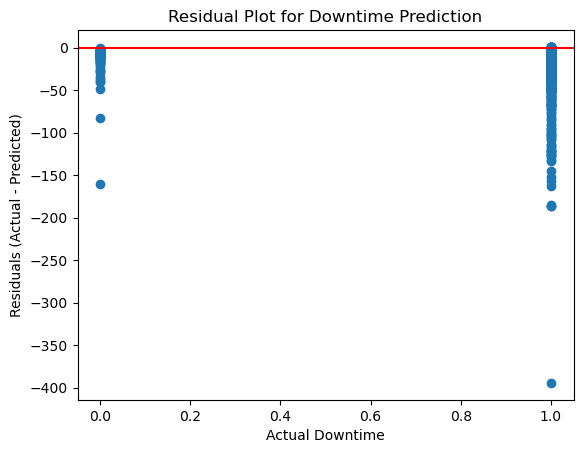

In [59]:
# Residual Plot for Regression
plt.scatter(y_test_breakdown[y_pred_breakdown == 1], y_test_breakdown[y_pred_breakdown == 1] - y_pred_downtime)
plt.axhline(y=0, color='r', linestyle='-')
plt.title("Residual Plot for Downtime Prediction")
plt.xlabel("Actual Downtime")
plt.ylabel("Residuals (Actual - Predicted)")
plt.show()

# Model Comparison and Tuning

In [61]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for tuning RandomForestClassifier
param_grid_clf = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5],
}

# Grid Search for Classification Model
grid_search_clf = GridSearchCV(clf_pipeline, param_grid_clf, cv=5, scoring='accuracy')
grid_search_clf.fit(X_train, y_train_breakdown)

print("Best parameters for classification:", grid_search_clf.best_params_)

# Define parameter grid for tuning RandomForestRegressor
param_grid_reg = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [10, 20, None],
    'regressor__min_samples_split': [2, 5],
}

# Grid Search for Regression Model
grid_search_reg = GridSearchCV(reg_pipeline, param_grid_reg, cv=5, scoring='neg_mean_absolute_error')
grid_search_reg.fit(X_train_downtime, y_train_downtime)

print("Best parameters for regression:", grid_search_reg.best_params_)


Best parameters for classification: {'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
Best parameters for regression: {'regressor__max_depth': 20, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 200}


# Save the Model for Future Use

In [67]:
import joblib

# Save the classification pipeline
joblib.dump(clf_pipeline, 'breakdown_classifier_pipeline.pkl')



['breakdown_classifier_pipeline.pkl']

In [69]:
# Save the regression pipeline
joblib.dump(reg_pipeline, 'downtime_regression_pipeline.pkl')


['downtime_regression_pipeline.pkl']